In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from pyswarm import pso
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

In [ ]:
df = pd.read_csv("heart_diseases.csv")
df.head()
df.columns

In [ ]:
bins = [0, 35, 55, float('inf')]
labels = [0, 1, 2] # We are ranking 0-35 age as younger age group (0), 35-55 as middle age (1), and 55+ as senior (2)
df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels).astype(int)

bins = [-float('inf'), 90, 120, 130, float('inf')]
labels = [1, 0, 2, 3] # We are ranking 0-90 as hypotension (1), 90-120 as normal(0), 120-130 as prehypertension (2), 130+ as hypertension (3)
df['RestingBP'] = pd.cut(df['RestingBP'], bins=bins, labels=labels).astype(float)

bins = [-float('inf'), 150, 200, float('inf')]
labels = [1, 0, 2] # We are ranking 0-150 as low cholesterol(1), 150-200 as normal (0), and 200+ as high cholesterol (2)
df['Cholesterol'] = pd.cut(df['Cholesterol'], bins=bins, labels=labels).astype(float)

bins = [0, 90, 130, 160, float('inf')]
labels = [1, 0, 2, 3] # We are ranking 0-90 as Brachycardia (1), 90-130 as normal (0), 130-160 as elevated heartrate (2), 160+ as Tachycardia (3)
df['MaxHR'] = pd.cut(df['MaxHR'], bins=bins, labels=labels).astype(float)

bins = [-float('inf'), 0, 1, 2, float('inf')]
labels = [0, 1, 2, 3] # We are ranking 0 as normal (0), 0-1 as mild (1), 1-2 as moderate (2), 2+ as severe (3)
df['Oldpeak'] = pd.cut(df['Oldpeak'], bins=bins, labels=labels).astype(float)

#One Hot Encode the binary related categorical features --> utilize dropping the column to eliminate collinearity
df_OH_encoded_1 = pd.get_dummies(df, columns=['Sex', 'ExerciseAngina'], drop_first=True)


#One Hot Encode the other features --> no need to drop columns
df_OH_encoded_2 = pd.get_dummies(df_OH_encoded_1, columns=['ChestPainType', 'RestingECG'])


#Labeling encode the features that have a ranking
st_slope_mapping = {'Up': 0, 'Flat': 1, 'Down': 2} # Ranking --> Up = normal (0), Flat = abnormal (1), Down = very abnormal
df_encoded = df_OH_encoded_2.copy()
df_encoded['ST_Slope'] = df_OH_encoded_2['ST_Slope'].map(st_slope_mapping)
print(df_encoded.head())

In [ ]:
plt.figure(figsize=(18, 6))
sns.countplot(x=df_encoded['Age'])
plt.title("Feature Variable Distribution - Age")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=df_encoded['Sex_M'])
plt.title("Feature Variable Distribution - Sex_M")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=df_encoded['ChestPainType_ASY'])
plt.title("Feature Variable Distribution - ChestPainType_ASY")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=df_encoded['ChestPainType_ATA'])
plt.title("Feature Variable Distribution - ChestPainType_ATA")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=df_encoded['ChestPainType_NAP'])
plt.title("Feature Variable Distribution - ChestPainType_NAP")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=df_encoded['ChestPainType_TA'])
plt.title("Feature Variable Distribution - ChestPainType_TA")
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(x=df_encoded['RestingBP'])
plt.title("Feature Variable Distribution - RestingBP")
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(x=df_encoded['Cholesterol'])
plt.title("Feature Variable Distribution - Cholesterol")
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(x=df_encoded['FastingBS'])
plt.title("Feature Variable Distribution - FastingBS")
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(x=df_encoded['RestingECG_Normal'])
plt.title("Feature Variable Distribution - RestingECG_Normal")
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(x=df_encoded['RestingECG_ST'])
plt.title("Feature Variable Distribution - RestingECG_ST")
plt.show()

plt.figure(figsize=(16, 6))
sns.countplot(x=df_encoded['MaxHR'])
plt.title("Feature Variable Distribution - MaxHR")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=df_encoded['ExerciseAngina_Y'])
plt.title("Feature Variable Distribution - ExerciseAngina_Y")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=df_encoded['Oldpeak'])
plt.title("Feature Variable Distribution - Oldpeak")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=df_encoded['ST_Slope'])
plt.title("Feature Variable Distribution - ST_Slope")
plt.show()

# Target Variable Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=df_encoded['HeartDisease'])
plt.title("Target Variable Distribution - HeartDisease")
plt.show()

correlation_matrix = df_encoded.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True,  cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()
correlation_list = correlation_matrix['HeartDisease'].sort_values(ascending=False)

print(correlation_list)

In [ ]:
X = df_encoded.drop(columns=['HeartDisease'])
y = df_encoded['HeartDisease']
# X = df.drop(columns=['HeartDisease'])
# y = df['HeartDisease']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold

def evaluate_model_cv(model, X_data, y_data, model_name, metrics_df, cv_folds=10):

    kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr']
    scores = cross_validate(model, X_data, y_data, cv=kfold, scoring=scoring, n_jobs=-1)
    results = {
        "Model": model_name,
        "Accuracy": scores['test_accuracy'].mean(),
        "Precision": scores['test_precision_weighted'].mean(),
        "Recall": scores['test_recall_weighted'].mean(),
        "F1 Score": scores['test_f1_weighted'].mean(),
        "ROC-AUC": scores['test_roc_auc_ovr'].mean()
    }
    metrics_df = pd.concat([metrics_df, pd.DataFrame([results])], ignore_index=True)
    print(f" {model_name} added to DataFrame.")
    return metrics_df

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
all_metrics_df= pd.DataFrame()
knn = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 7, weights= 'uniform')
all_metrics_df=evaluate_model_cv(knn, X_train, y_train, "KNN", all_metrics_df)

 KNN added to DataFrame.


In [ ]:
all_metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,KNN,0.82399,0.827175,0.82399,0.823303,0.888047


In [ ]:
#Naive-Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(var_smoothing= 0.1)
all_metrics_df=evaluate_model_cv(gnb, X_train, y_train, "Naive-Bayes", all_metrics_df)

 Naive-Bayes added to DataFrame.


In [ ]:
#Logistic Regression
lg = LogisticRegression(C= 0.1, penalty='l2', solver= 'liblinear')
all_metrics_df=evaluate_model_cv(lg, X_train, y_train, "Logistic Regression", all_metrics_df)

 Logistic Regression added to DataFrame.


In [ ]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt_regularized = DecisionTreeClassifier(
    max_depth=100,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
all_metrics_df=evaluate_model_cv(dt_regularized, X_train, y_train, "Decision Tree", all_metrics_df)

 Decision Tree added to DataFrame.


In [ ]:
#Random Forest
rfc = RandomForestClassifier(bootstrap= True, max_depth= 5, min_samples_split =5, n_estimators=100)
all_metrics_df=evaluate_model_cv(rfc, X_train, y_train, "Random Forest", all_metrics_df)

 Random Forest added to DataFrame.


In [ ]:
#SVM
svcf = SVC(C=1.0, gamma = 'scale', kernel = 'rbf', probability = True)
all_metrics_df=evaluate_model_cv(svcf, X_train, y_train, "SVM", all_metrics_df)

 SVM added to DataFrame.


In [ ]:
all_metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,KNN,0.823990,0.827175,0.823990,0.823303,0.888047
1,Naive-Bayes,0.831779,0.833128,0.831779,0.831340,0.908424
2,Logistic Regression,0.831755,0.834169,0.831755,0.831044,0.902159
3,Decision Tree,0.812957,0.814577,0.812957,0.812669,0.869673
4,Random Forest,0.850457,0.853150,0.850457,0.849621,0.921662
5,SVM,0.862837,0.865810,0.862837,0.862173,0.910754


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective="binary:logistic",learning_rate = 0.01,n_estimators = 200, random_state=42)
all_metrics_df=evaluate_model_cv(xgb, X_train, y_train, "XGBoost", all_metrics_df)

 XGBoost added to DataFrame.


In [ ]:
base_models = [
    ('svm', SVC(kernel='rbf', C=10, probability=True, random_state=42,)),
    ('rf', RandomForestClassifier(bootstrap= True, max_depth= 5, min_samples_split =5, n_estimators=100)),
]

# Define meta-model
meta_model = LogisticRegression(penalty= 'l2', solver='liblinear')

# Create stacking classifier
stacking_all = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=10)

In [ ]:
all_metrics_df = evaluate_model_cv(stacking_all, X_train, y_train, "Stacking", all_metrics_df)

 Stacking added to DataFrame.


In [ ]:
all_metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,KNN,0.823990,0.827175,0.823990,0.823303,0.888047
1,Naive-Bayes,0.831779,0.833128,0.831779,0.831340,0.908424
2,Logistic Regression,0.831755,0.834169,0.831755,0.831044,0.902159
3,Stacking,0.858221,0.861095,0.858221,0.857621,0.922529


In [ ]:
from sklearn.svm import SVC
import joblib

svm_model = SVC(probability=True, kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

# Save the model
#joblib.dump(stacking_all, 'stacking_model.pkl')
joblib.dump(svm_model, 'svm_model.pkl')
#
# ✅ Save the feature column order
joblib.dump(X_train.columns.tolist(), 'feature_columns.pkl')


['feature_columns.pkl']

In [ ]:
all_metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,KNN,0.823990,0.827175,0.823990,0.823303,0.888047
1,Naive-Bayes,0.831779,0.833128,0.831779,0.831340,0.908424
2,Logistic Regression,0.831755,0.834169,0.831755,0.831044,0.902159
3,Stacking,0.858221,0.861095,0.858221,0.857621,0.922529


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def get_oof_predictions(base_models, X, y, n_folds=10):
    """Generate out-of-fold predictions for each base model."""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    oof_preds = np.zeros((X.shape[0], len(base_models)))

    for i, (name, model) in enumerate(base_models):
        print(f"Training base model: {name}")
        for train_idx, valid_idx in skf.split(X, y):
            X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
            X_valid_fold = X.iloc[valid_idx]

            model.fit(X_train_fold, y_train_fold)
            oof_preds[valid_idx, i] = model.predict_proba(X_valid_fold)[:, 1]  # Using probability as meta feature

    return oof_preds  # shape: (n_samples, n_base_models)


def evaluate_manual_stacking_cv(base_models, meta_model, X, y, model_name, metrics_df, cv_folds=10):
    """Evaluate manual stacking using cross-validation."""
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    acc_list, prec_list, rec_list, f1_list, roc_list = [], [], [], [], []

    for train_idx, test_idx in skf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        # Get OOF predictions for base models
        oof_train_preds = get_oof_predictions(base_models, X_train, y_train, n_folds=cv_folds)

        # Train meta-model on OOF predictions
        meta_model.fit(oof_train_preds, y_train)

        # Generate test set meta features from base models
        test_preds = []
        for name, model in base_models:
            model.fit(X_train, y_train)
            test_preds.append(model.predict_proba(X_test)[:, 1])

        stacked_test_input = np.column_stack(test_preds)

        # Meta model prediction
        y_pred = meta_model.predict(stacked_test_input)
        y_proba = meta_model.predict_proba(stacked_test_input)[:, 1]

        # Metrics
        acc_list.append(accuracy_score(y_test, y_pred))
        prec_list.append(precision_score(y_test, y_pred, average='weighted'))
        rec_list.append(recall_score(y_test, y_pred, average='weighted'))
        f1_list.append(f1_score(y_test, y_pred, average='weighted'))
        roc_list.append(roc_auc_score(y_test, y_proba, multi_class='ovr' if len(np.unique(y)) > 2 else 'raise'))

    results = {
        "Model": model_name,
        "Accuracy": np.mean(acc_list),
        "Precision": np.mean(prec_list),
        "Recall": np.mean(rec_list),
        "F1 Score": np.mean(f1_list),
        "ROC-AUC": np.mean(roc_list)
    }

    metrics_df = pd.concat([metrics_df, pd.DataFrame([results])], ignore_index=True)
    print(f"{model_name} added to DataFrame.")
    return metrics_df
all_metrics_df = evaluate_manual_stacking_cv(base_models, meta_model, X_train, y_train, "Manual Stacking", all_metrics_df)

In [ ]:
all_metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,KNN,0.823990,0.827175,0.823990,0.823303,0.888047
1,Naive-Bayes,0.831779,0.833128,0.831779,0.831340,0.908424
2,Logistic Regression,0.831755,0.834169,0.831755,0.831044,0.902159
3,Stacking,0.858221,0.861095,0.858221,0.857621,0.922529
4,Manual Stacking,0.858221,0.860582,0.858221,0.857812,0.921849


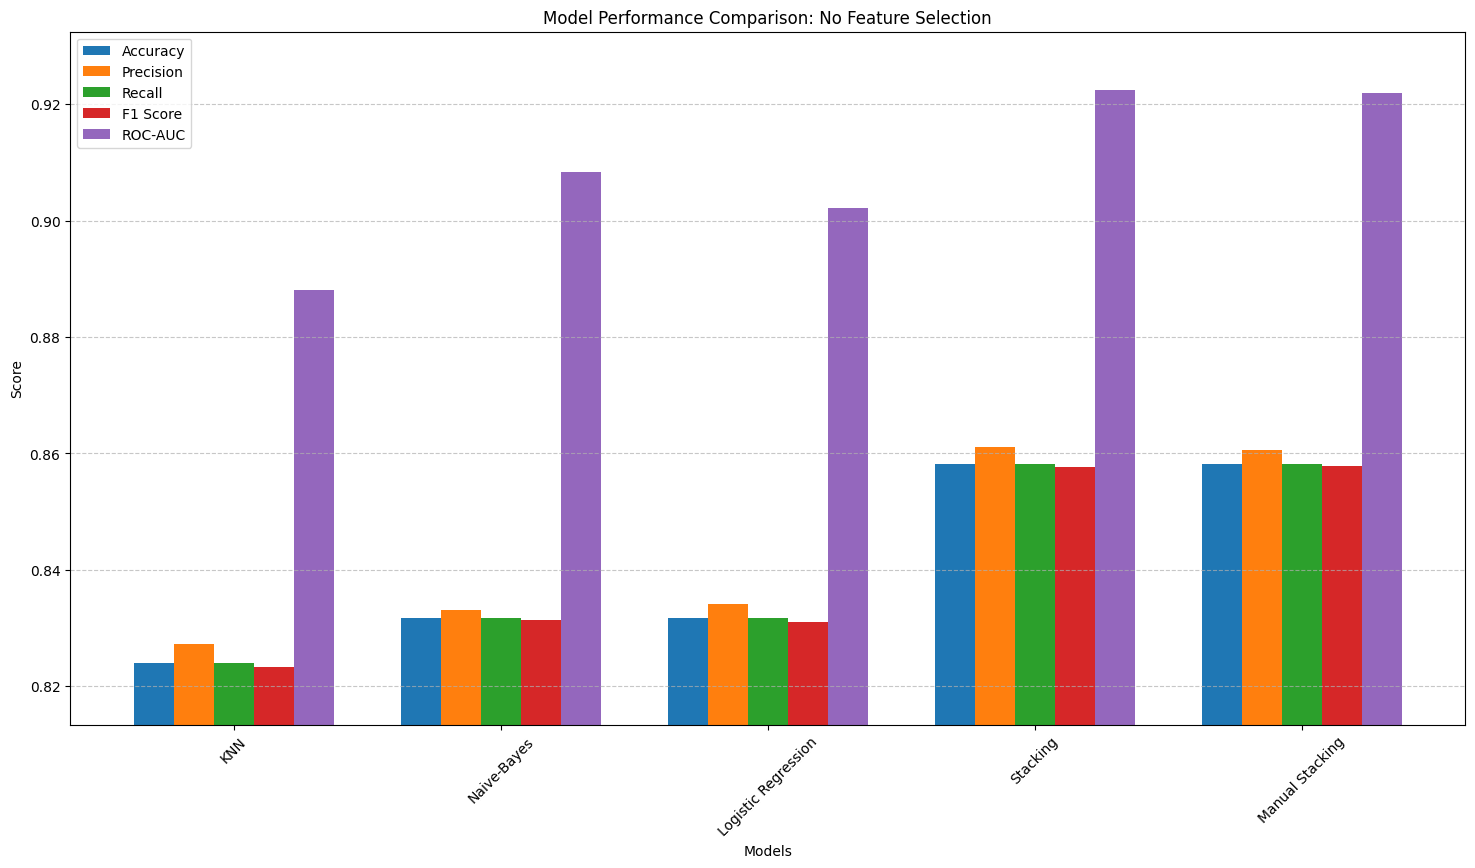

In [ ]:
plt.figure(figsize=(18, 9))

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
models = all_metrics_df["Model"]
bar_width = 0.15
x = np.arange(len(models))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, all_metrics_df[metric], width=bar_width, label=metric)

plt.xticks(x + bar_width * 2, models, rotation=45)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Performance Comparison: No Feature Selection")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

y_min = all_metrics_df[metrics].min().min()
y_max = all_metrics_df[metrics].max().max()
padding = (y_max - y_min) * 0.1
plt.ylim(y_min - padding, y_max + padding)
plt.show()